# osm_LoD1_3DCityModel Walkthrough

**The purpose of this notebook is to walk a user through [osm_LoD1_3DCityModel](https://github.com/AdrianKriger/osm_LoD1_3DCityModel/tree/main/village_campus).**


<div class="alert alert-block alert-warning"><b>This notebook will:</b>

> **1. allow the user to create a Level-of-Detail 1 (LoD1) [3D City Model](https://en.wikipedia.org/wiki/3D_city_model).**  *---It saves the `overpass`.geojson to prevent calling OSM after every failure. Peruse `matplotlib` figure at you leisure.* 
>
> **2. propose several [Geography and Sustainable Development Education *conversation starters*](#Section2) for Secondary and Tertiary level students**
</div>

In [1]:
import time
from datetime import timedelta

import os
from itertools import chain#, izip

import requests
import overpass
import osm2geojson

import pyrosm

import numpy as np
import pandas as pd
import geopandas as gpd
import topojson as tp

import shapely
import shapely.geometry as sg
from shapely.geometry import Point, LineString, Polygon, MultiPolygon, LinearRing, shape, mapping
from shapely.ops import snap
from shapely.ops import transform

import fiona
import copy
import json
import geojson

import pyproj

import city3D

from osgeo import gdal, ogr, osr

import triangle as tr

from openlocationcode import openlocationcode as olc

import matplotlib.pyplot as plt

In [2]:
import warnings
#warnings.filterwarnings('ignore')

**A `parameter.json` defines the path and files**.

In [38]:
jparams = json.load(open('osm3DwStock_param.json'))        #- wait for update
#jparams = json.load(open('osm3DsRiver_param.json'))       #- fine
#jparams = json.load(open('osm3Dobs_param.json'))          #- wait for update

**Harvest [OpenStreetMap](https://en.wikipedia.org/wiki/OpenStreetMap)** - interogate an osm.pbf (["Protocolbuffer Binary Format"](https://wiki.openstreetmap.org/wiki/PBF_Format)) with [pyrosm]() from within Jupyter and convert to .geojson.

<div class="alert alert-block alert-info"><b></b> 
    
We start with a blank slate at a `country-level.osm.pbf`. 
</div>

In [4]:
# update=False to use an existing osm.pbf
fp = pyrosm.get_data("South Africa", update=False, directory="data")

#- city-level will not produce same result as country-level.osm.pbf [not updated as regularly]
#fp = pyrosm.get_data("Cape Town", update=True, directory="data")  

In [39]:
#- get the area [suburb]

query = """[out:json][timeout:30];
            area[boundary=administrative][name='{0}'];
            wr[place~"^(sub|town|city|count|state)"][name='{1}'](area);
            out geom;
        """.format(jparams['LargeArea'], jparams['FocusArea'])

url = "http://overpass-api.de/api/interpreter"
r = requests.get(url, params={'data': query})
#rr = r.read()
area = osm2geojson.json2geojson(r.json())
#read into .gpd
aoi = gpd.GeoDataFrame.from_features(area['features'])
aoi = aoi.set_crs(4326, allow_override=True)

In [40]:
#ts.crs

In [41]:
start = time.time()

# get the shapely geometry from the aoi.GeoDataFrame
bbox_geom = aoi['geometry'].values[0]
# initiliaze with bounding box
osm = pyrosm.OSM(fp, bounding_box=bbox_geom)
# retrieve buildings
ts = osm.get_buildings(extra_attributes=['addr:suburb', 'building:part', 'rooms', 'beds', 'residential', 'building:min_level'])
#ts = ts.set_crs(4326, allow_override=True)

print(len(ts), ' buildings')
end = time.time()
print('runtime:', str(timedelta(seconds=(end - start))))

3772  buildings
runtime: 0:02:13.766446


In [42]:
# basic cleaning to harvest building=* (no building:part=*) and building=levels tags only

ts.dropna(subset=['building:levels'], inplace= True)
ts['building:levels'] = pd.to_numeric(ts['building:levels'], downcast='integer')
ts['building:levels'] = ts['building:levels'].astype(int)
#- we only want buildings with =levels data
ts = ts[ts['building:levels'] != 0]
ts['building:levels'] = ts['building:levels'].replace('None', np.nan)#, inplace=True)
ts = ts[ts['building:levels'].notna()]

#- without building:part
ts = ts[ts['building:part'].isnull()]

In [43]:
# have a look
ts.head(2)

,addr:city,addr:country,addr:housenumber,addr:housename,addr:postcode,addr:street,email,name,opening_hours,operator,phone,ref,visible,website,building,amenity,building:flats,building:levels,building:use,craft,height,internet_access,office,shop,source,start_date,wikipedia,addr:suburb,building:part,rooms,beds,residential,id,timestamp,version,geometry,tags,osm_type,changeset
1,None,None,None,None,None,None,None,None,None,None,None,None,False,None,industrial,None,None,1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,239784858,1677943636,3,"POLYGON ((18.44740 -33.92310, 18.44806 -33.923...","{""layer"":""1""}",way,NaN
2,Cape Town,None,93,None,None,Victoria Road,None,SAPS Woodstock Police Station,24/7,South African Police Service,None,None,False,None,police,police,None,2,None,None,None,None,None,None,None,None,None,Woodstock,None,None,None,None,286863970,1722058805,4,"POLYGON ((18.44822 -33.92910, 18.44806 -33.929...","{""operator:short"":""SAPS"",""operator:wikidata"":""...",way,NaN


In [44]:
#ts['min_height'] = ts['tags'].apply(lambda x: x.get('min_height'))
ts['min_height'] = ts['tags'].get('min_height')#.get('b')
#ts.min_height.unique()

In [45]:
#file = open(jparams['ori-gjson_out'])
#gdf = gpd.read_file(file)
#- coordinate reference system
ts.crs
#aoi.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<img src="data/proj.png" alt="proj" width="550" align="right"/>
<br>
<br>

We need the ***Projected*** Coordinate Reference System.  

In [46]:
#- estimate utm: internal geopandas function
ts.estimate_utm_crs()

<Projected CRS: EPSG:32734>
Name: WGS 84 / UTM zone 34S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 18°E and 24°E, southern hemisphere between 80°S and equator, onshore and offshore. Angola. Botswana. Democratic Republic of the Congo (Zaire). Namibia. South Africa. Zambia.
- bounds: (18.0, -80.0, 24.0, 0.0)
Coordinate Operation:
- name: UTM zone 34S
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<div class="alert alert-block alert-danger"><b>Your Participation! </b>
    
**Fill in the proper `espg` in the _`cell`_ below** </div>

In [47]:
#- fill <Projected CRS: EPSG:32734> from above here epsg = EPSG:32734
epsg = 'EPSG:32734'

In [48]:
#project blds
ts = ts.to_crs(epsg)
#project aoi
aoi = aoi.to_crs(epsg)

**Now we process.**  

In [49]:
aoibuffer = aoi.copy()

def buffer01(row):
    with np.errstate(invalid='ignore'):
        return row.geometry.buffer(150, cap_style=3, join_style=2)

aoibuffer['geometry'] = aoibuffer.apply(buffer01, axis=1)
    
extent = [aoibuffer.total_bounds[0] - 250, aoibuffer.total_bounds[1] - 250, 
          aoibuffer.total_bounds[2] + 250, aoibuffer.total_bounds[3] + 250]

**Now the DEM**  
*one is available at [raster](https://github.com/AdrianKriger/geo3D/suburb/tree/main/raster)*

In [50]:
gdal.SetConfigOption("GTIFF_SRS_SOURCE", "GEOKEYS")
gdal.UseExceptions() 

# set the path and nodata
OutTile = gdal.Warp(jparams['projClip_raster'], 
                    jparams['in_raster'],
                    dstSRS=epsg,
                    srcNodata = jparams['nodata'],
                    #-  dstNodata = 0,
                    #-- outputBounds=[minX, minY, maxX, maxY]
                    outputBounds = [extent[0], extent[1], extent[2], extent[3]])
OutTile = None 

In [51]:
# raster to xyz
xyz = gdal.Translate(jparams['xyz'], 
                     jparams['projClip_raster'],
                     format = 'XYZ')#, 
                     #noData = float(0))
xyz = None

**prepare to harvest elevation**

In [52]:
# set the path to the projected, cliped elevation
src_filename = jparams['projClip_raster']

src_ds = gdal.Open(src_filename) 
gt_forward = src_ds.GetGeoTransform()
rb = src_ds.GetRasterBand(1)

def rasterQuery(geom, gt_forward, rb):

    mx = geom.representative_point().x
    my = geom.representative_point().y
    
    px = int((mx - gt_forward[0]) / gt_forward[1])
    py = int((my - gt_forward[3]) / gt_forward[5])

    intval = rb.ReadAsArray(px, py, 1, 1)
 
    return intval[0][0]

**Buildings**

In [53]:
#- harvest buildings
#ts = gpd.read_file(jparams['gjson-proj_out'])
#ts['bld'] = ts['tags'].apply(lambda x: x.get('building'))
#ts.drop(ts.index[ts['type'] == 'node'], inplace = True)

#- orient segments and simplify topology
topo = tp.Topology(ts, prequantize=False, winding_order='CCW_CW')
#ts = topo.toposimplify(0.2).to_gdf()
with np.errstate(invalid='ignore'):
    ts = topo.toposimplify(0.2).to_gdf()

/Users/adriankriger/miniconda3/envs/geo3D_distV2/lib/python3.9/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


In [ ]:
# prepare to plot (more buildings = more time) 
start = time.time()

ts_copy = ts.copy()
new_df1 = ts_copy.loc[ts_copy.overlaps(ts_copy.unary_union)].reset_index(drop=True)  #-- perhaps no union?
#new_df1 = ts_copy.loc[ts_copy.overlaps(ts_copy.unary_union)] #-- perhaps no union?
#new_df1 = ts_copy.loc[ts_copy.overlaps(ts_copy)].reset_index(drop=True)  #-- perhaps no union?

ts_copy.drop(ts_copy.index[ts_copy['building'] == 'bridge'], inplace = True)
ts_copy.drop(ts_copy.index[ts_copy['building'] == 'roof'], inplace = True)

end = time.time()
print('runtime:', str(timedelta(seconds=(end - start))))

In [21]:
#  !!!--- work around until osm.pbf is updated; to check if process works
ts = pd.merge(ts, new_df1, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)

**Plot**

*Browse the saved `'./data/topologyFig'` at your leisure*

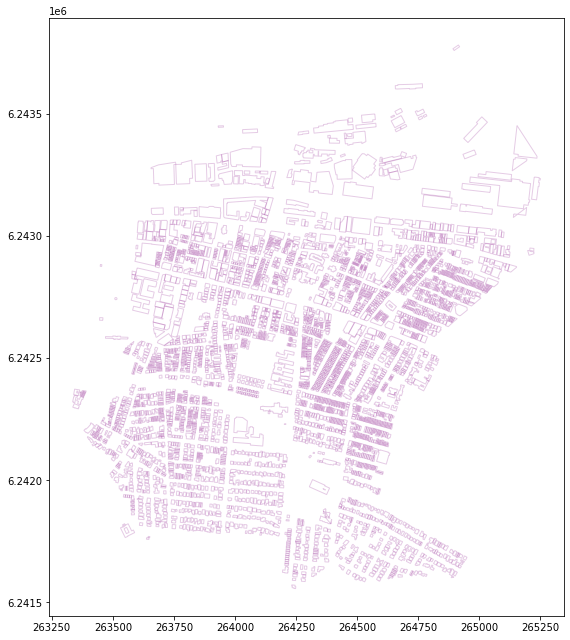

In [55]:
#%matplotlib

fig, ax = plt.subplots(figsize=(11, 11))

ts.plot(ax=ax, facecolor='none', edgecolor='purple', alpha=0.2)
#if len(new_df1) > 0:
    #new_df1.plot(ax=ax, edgecolor='red', facecolor='none')#, alpha=0.3)#, column='osm_building', legend=True)

#-- save
plt.savefig('./data/topologyFig', dpi=300)
#plt.show()

|  |  |
|:--------:|:--------:|
|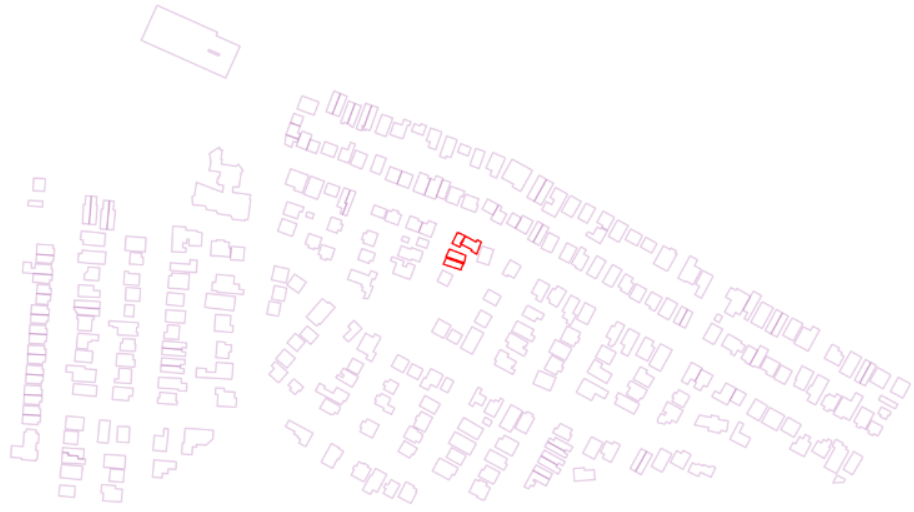 | **Challenges will be highlight in *Red*.**|
|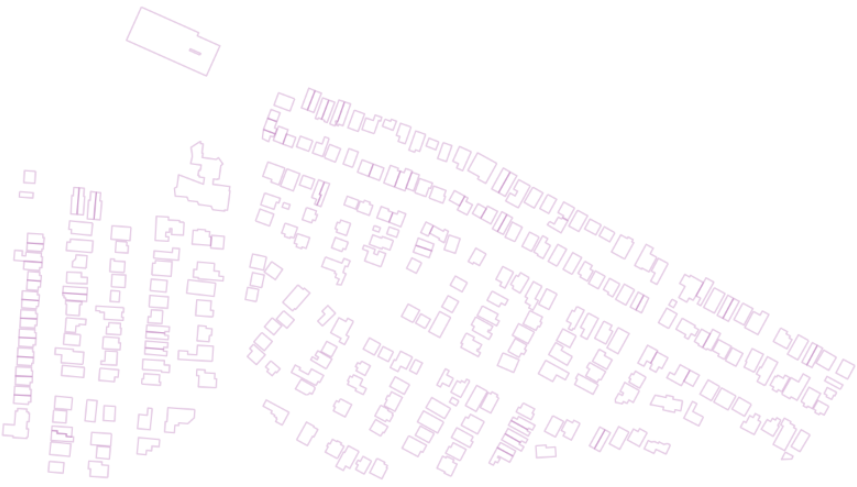| **or none**|
|<br /> **If you continue without fixing the challenges, the LoD1 City Model *will not be error free*.** | <br /> **Our goal is a topologically correct surface.** |

<h2><center>Please ensure the quality of the value-added product and the source data.</center></h2>

**If necessary; edit [OpenStreetMap](https://www.openstreetmap.org/about) and fix the challenge please.**

<div class="alert alert-block alert-warning"><b></b>
    
And remember.  
Geofabrik releases a ***fresh `.osm.pbf` EVERYDAY!***  
Give the OpenStreetMap server ***at least a day*** before attempting the process again.
    
**Alchemy is a process. Please be patient.**
</div>

In [23]:
#- get the mean height of the bld
ts['mean'] = ts.apply(lambda row: rasterQuery(row.geometry, gt_forward, rb), axis = 1)
ts.head(2)

,geometry,addr:city,addr:country,addr:housenumber,addr:housename,addr:postcode,addr:place,addr:street,email,name,opening_hours,operator,phone,visible,website,building,amenity,building:flats,building:levels,building:use,craft,height,internet_access,office,shop,source,start_date,wikipedia,addr:suburb,building:part,rooms,beds,residential,id,timestamp,version,tags,osm_type,changeset,min_height,mean
0,"POLYGON ((265576.191 6242478.021, 265567.611 6...",Cape Town,None,70,None,None,None,Kingsley Road,None,None,None,None,None,False,None,house,None,None,1,None,NaN,NaN,NaN,None,None,None,None,None,Salt River,NaN,None,None,None,1063016734,1653331130,1,None,way,NaN,None,14.920000
1,"POLYGON ((264985.719 6242444.774, 264975.443 6...",Cape Town,None,261,None,None,None,Victoria Road,None,None,None,None,None,False,None,retail,None,None,1,None,NaN,NaN,NaN,None,None,None,None,None,Salt River,NaN,None,None,None,1022334746,1643706790,2,None,way,NaN,None,25.379999


<div class="alert alert-block alert-warning"><b>Calculate building height:</b> 

We assume a building level is 2.8 meters high and add another 1.3 meters (to account for the roof) and create a new attribute `height`.</div>

The Python code to execute the `.writejson` function is in the `city3D.py` script

In [23]:
# -- execute function. write geoJSON
city3D.writegjson(ts, jparams, epsg)

KeyError: 'type'

In [24]:
#-- take care of non-Polygon LineString's 
for i, row in ts.iterrows():
    if row.geometry.geom_type == 'LineString' and len(row.geometry.coords) < 3:
        ts = ts.drop(ts.index[i])

storeyheight = 2.8
#-- iterate through the list of buildings and create GeoJSON features rich in attributes
footprints = {
    "type": "FeatureCollection",
    "features": []
    }

columns = ts.columns   
for i, row in ts.iterrows():
    f = {
    "type" : "Feature"
    }
    f["properties"] = {}      
        #-- store all OSM attributes and prefix them with osm_ 
    f["properties"]["osm_id"] = row.id
    adr = []
            #-- transform the OSM address to string prefix with osm_
    if 'addr:housename' in columns and row['addr:housename'] != None:
        adr.append(row['addr:housename'])
    if 'addr:flats' in columns and row['addr:flats'] != None:
        adr.append(row['addr:flats'])
    if 'addr:housenumber' in columns and row['addr:housenumber'] != None:
        adr.append(row['addr:housenumber'])
    if 'addr:street' in columns and row['addr:street'] != None:
        adr.append(row['addr:street'])
    if 'addr:suburb' in columns and row['addr:suburb'] != None:
        adr.append(row['addr:suburb'])
    if 'addr:postcode' in columns and row['addr:postcode'] != None:
        adr.append(row['addr:postcode'])
    if 'addr:city' in columns and row['addr:city'] != None:
        adr.append(row['addr:city'])
    if 'addr:province' in columns and row['addr:province'] != None:
        adr.append(row['addr:province'])
    
    f["properties"]["osm_address"] = " ".join(adr)
    
    # harvest some tags ~ we could harvest all but lets do less
    if 'building' in columns and row['building'] != None:
        f["properties"]["osm_building"] = row['building']
    if 'building:levels' in columns and row['building:levels'] != None:
        f["properties"]["osm_building:levels"] = row['building:levels']
    if 'building:flats' in columns and row['building:flats'] != None:
        f["properties"]["osm_building:flats"] = row['building:flats']
    if 'beds' in columns and row['beds'] != None:
        f["properties"]["osm_building:beds"] = row['beds']
    if 'rooms' in columns and row['rooms'] != None:
        f["properties"]["osm_building:rooms"] = row['rooms']
    if 'residential' in columns and row['residential'] != None:
        f["properties"]["residential"] = row['residential']
    if 'amenity' in columns and row['amenity'] != None:
        f["properties"]["amenity"] = row['amenity']
          
    osm_shape = row["geometry"] # shape(row["geometry"][0])
        #-- a few buildings are not polygons, rather linestrings. This converts them to polygons
        #-- rare, but if not done it breaks the code later
    if osm_shape.geom_type == 'LineString':
        osm_shape = Polygon(osm_shape)
        #-- and multipolygons must be accounted for
    elif osm_shape.geom_type == 'MultiPolygon':
            #osm_shape = Polygon(osm_shape[0])
            polys = list(osm_shape.geoms) 
            for poly in polys:
                osm_shape = Polygon(poly)#[0])

    f["geometry"] = mapping(osm_shape)

    # harvest some tags ~ we could harvest all but lets do less
    if 'building' in columns and row['building'] != None:
        f["properties"]["osm_building"] = row['building']
    if 'building:levels' in columns and row['building:levels'] != None:
        f["properties"]["osm_building:levels"] = row['building:levels']
    if 'building:flats' in columns and row['building:flats'] != None:
        f["properties"]["osm_building:flats"] = row['building:flats']
    if 'beds' in columns and row['beds'] != None:
        f["properties"]["osm_building:beds"] = row['beds']
    if 'rooms' in columns and row['rooms'] != None:
        f["properties"]["osm_building:rooms"] = row['rooms']
    if 'residential' in columns and row['residential'] != None:
        f["properties"]["residential"] = row['residential']
    if 'amenity' in columns and row['amenity'] != None:
        f["properties"]["amenity"] = row['amenity']
        
    osm_shape = shape(row["geometry"])
        #-- a few buildings are not polygons, rather linestrings. This converts them to polygons
        #-- rare, but if not done it breaks the code later
    if osm_shape.geom_type == 'LineString':
        osm_shape = Polygon(osm_shape)
    #-- and multipolygons must be accounted for
    elif osm_shape.geom_type == 'MultiPolygon':
        polys = list(osm_shape.geoms) 
        for poly in polys:
            osm_shape = Polygon(poly)#[0])
        
    f["geometry"] = mapping(osm_shape)
    f["properties"]["footprint"] = mapping(osm_shape)
        
    #-- google plus_code
    p = osm_shape.representative_point()
    f["properties"]["plus_code"] = olc.encode(p.y, p.x, 11)
        
    if row['building'] == 'bridge':
        f["properties"]['ground_height'] = round(row["mean"], 2)
        #print('id: ', f["properties"]["osm_id"], row.tags['building:levels'])
        if row['tags']['min_height'] != None:
            f["properties"]['bottom_bridge_height'] = round(float(row['min_height']) + row["mean"], 2)
        else:
            f["properties"]['bottom_bridge_height'] = round((float(row['building:min_level']) * storeyheight) + row["mean"], 2)
        f["properties"]['building_height'] = round(float(row['building:levels']) * storeyheight, 2)
        f["properties"]['roof_height'] = round(f["properties"]['building_height'] + row["mean"], 2)
    if row['building'] == 'roof':
        f["properties"]['ground_height'] = round(row["mean"], 2)
        f["properties"]['bottom_roof_height'] = round(float(row['building:levels']) * storeyheight + row["mean"], 2) 
        f["properties"]['roof_height'] = round(f["properties"]['bottom_roof_height'] + 1.5, 2)
    if row['building'] != 'bridge' and row['building'] != 'roof':
        f["properties"]['ground_height'] = round(row["mean"], 2)
        f["properties"]['building_height'] = round(float(row['building:levels']) * storeyheight + 1.3, 2) 
        f["properties"]['roof_height'] = round(f["properties"]['building_height'] + row["mean"], 2)
               
        #f["properties"]['ground_height'] = round(row["mean"], 2)
        #f["properties"]['building_height'] = round(int(row['building:levels']) * storeyheight + 1.3, 2) 
        #f["properties"]['roof_height'] = round(f["properties"]['building_height'] + row["mean"], 2)
        
    footprints['features'].append(f)
            
#-- store the data as GeoJSON
with open(jparams['osm_bldings'], 'w') as outfile:
    json.dump(footprints, outfile)

In [25]:
from shapely.geometry import polygon
import math

start = time.time()

dis = gpd.read_file(jparams['osm_bldings'])                   
dis.set_crs(epsg=int(epsg[-5:]), inplace=True, allow_override=True)

dict_vertices = {}
cols = [c for c in ['bottom_bridge_height', 'bottom_roof_height', 'roof_height'] if c in dis.columns]

dis['geometry'] = dis.geometry.apply(polygon.orient, 1)

for i, row in dis.iterrows():
    oring = list(row.geometry.exterior.coords)
    name = row['osm_id']
    for (j, v) in enumerate(oring[:-1]):
        vertex = (oring[j][0], oring[j][1])
        attr = [row[c] for c in cols]
        attr = [x for x in attr if not np.isnan(x)]  # Remove np.nan values
        if vertex in dict_vertices.keys():
            dict_vertices[vertex][row['osm_id']] = attr
        else:
            dict_vertices[vertex] = {row['osm_id']: attr}

result = {}
for k1, d in dict_vertices.items():
    for k2 in d:
        result.setdefault(k2, {})[k1] = sorted(list(set([j for i in d.values() for j in i])))
        
dis.drop(dis.index[dis['osm_building'] == 'bridge'], inplace = True)
dis.drop(dis.index[dis['osm_building'] == 'roof'], inplace = True)

#- create a point representing the hole within each building  
dis['x'] = dis.representative_point().x
dis['y'] = dis.representative_point().y
hs = dis[['x', 'y', 'ground_height']].copy()

end = time.time()
print('runtime:', str(timedelta(seconds=(end - start))))

runtime: 0:00:00.345787


/Users/adriankriger/miniconda3/envs/geo3D_distV2/lib/python3.9/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


In [26]:
dis.head(2)

,osm_id,osm_address,osm_building,osm_building:levels,osm_building:beds,osm_building:flats,osm_building:rooms,residential,amenity,footprint,plus_code,ground_height,bottom_roof_height,building_height,roof_height,geometry,x,y
0,1063016734,70 Kingsley Road Salt River Cape Town,house,1,NaN,NaN,NaN,NaN,NaN,"{'type': 'Polygon', 'coordinates': [[[265576.1...",C5XFXPXH+X4V,14.92,NaN,4.1,19.02,"POLYGON ((265576.191 6242478.021, 265567.611 6...",265569.727808,6.242476e+06
1,1022334746,261 Victoria Road Salt River Cape Town,retail,1,NaN,NaN,NaN,NaN,NaN,"{'type': 'Polygon', 'coordinates': [[[264985.7...",CGXFXPX9+XPW,25.38,NaN,4.1,29.48,"POLYGON ((264985.719 6242444.774, 264975.443 6...",264989.719318,6.242431e+06


**prepare the elevation for the TIN**

In [27]:
#- 
dis_c = dis.copy()

In [28]:
#- prepare xyz (more buildings = more time)
start = time.time()

df = pd.read_csv(jparams['xyz'],                                      
                 delimiter = ' ', header=None, names=["x", "y", "z"])
    
geometry = [Point(xy) for xy in zip(df.x, df.y)]
gdf = gpd.GeoDataFrame(df, crs=epsg, geometry=geometry)                    
    
_symdiff = gpd.overlay(aoibuffer, dis_c, keep_geom_type=False, how='symmetric_difference') 
_mask = gdf.within(_symdiff.loc[0, 'geometry'])
gdf = gdf.loc[_mask]
gdf = gdf[gdf['z'] != jparams['nodata']]                              
gdf.reset_index(drop=True, inplace=True)
gdf = gdf.round(2)

end = time.time()
print('runtime:', str(timedelta(seconds=(end - start))))

runtime: 0:01:52.183018


<div class="alert alert-block alert-warning"><b>Prepare for Triangle:</b> </div>

The Python code to execute the `city3D.functions` are in the `city3D.py` script

In [29]:
#- harvest the building vertices. typically the corners. 
ac, c, min_zbld = city3D.getBldVertices(dis, gt_forward, rb)
idx = []
#- segments 
idx, idx01 = city3D.createSgmts(ac, c, gdf, idx)
#- populate the .df with coordinate values (the vertices)
df2 = city3D.concatCoords(gdf, ac)

#- do the same for the area of interest
acoi, ca = city3D.getAOIVertices(aoibuffer, gt_forward, rb)
idx, idx01 = city3D.createSgmts(acoi, ca, df2, idx)
df3 = city3D.concatCoords(df2, acoi)

**Triangle**

In [30]:
pv_pts = df3[['x', 'y', 'z']].values

In [31]:
pts = df3[['x', 'y']].values 
A = dict(vertices=pts)
Tr = tr.triangulate(A)

In [32]:
holes01 = hs[['x', 'y']].round(3).values.tolist()
pts = df3[['x', 'y']].values #, 'z']].values

#the terrain without the blds
A = dict(vertices=pts, segments=idx, holes=holes01)

Tr = tr.triangulate(A)                  
terrTin = Tr.get('triangles').tolist()

In [33]:
#terrTin

**CityJSON**

In [34]:
#- 
minz = df3['z'].min()
maxz = df3['z'].max()

In [35]:
#min_zbld

<div class="alert alert-block alert-warning"><b>create CityJSON</b> </div>

The Python code to execute the `.output_cityjson` function is in the `city3D.py` script

In [36]:
# -- execute function. create CityJSON
city3D.output_cityjson(extent, minz, maxz, terrTin, pv_pts, jparams, min_zbld, acoi, result) 

In [37]:
src_ds = None

<div class="alert alert-block alert-info"><b></b> 

**Go over to [Ninja the online CityJSON viewer](https://ninja.cityjson.org/#) and explore!**

</div>

**You are welcome to further investigate the quality of a 3D Model.**

**The [val3dity](http://geovalidation.bk.tudelft.nl/val3dity/) web app will test CityJSON geometric primitives.**

If you parse the result of this notebook through [val3dity](http://geovalidation.bk.tudelft.nl/val3dity/) it will return a report: **100% valid!<sup>*</sup>**

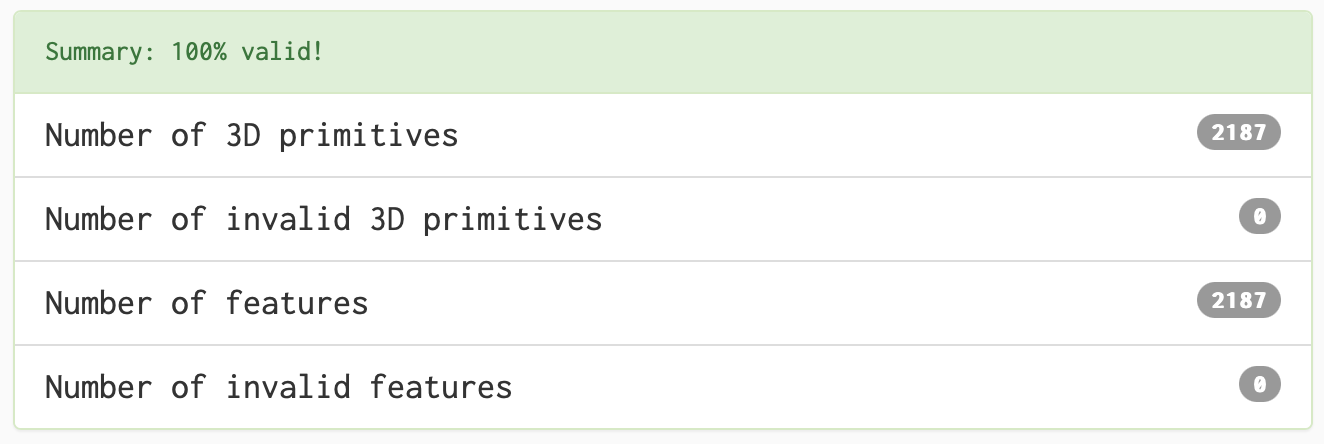

<sup>* *your model conforms to the ISO 19107 standard [connecting and planar surfaces, correct orientation of the surfaces and watertight volumes]*

<div class="alert alert-block alert-warning"><b>NOW</b><br><br>


***To understand the value and usefulness of a 3D City Model***; parse the result of this Notebook through [CityJSONspatialDataScience.ipynb](https://github.com/AdrianKriger/geo3D/blob/main/CityJSONspatialDataScience.ipynb) to workthrough an example of:  
- population estimation and
- a calculation of [Building Volume per Capita]((https://www.researchgate.net/publication/343185735_Building_Volume_Per_Capita_BVPC_A_Spatially_Explicit_Measure_of_Inequality_Relevant_to_the_SDGs)
</div>

***As always; you are welcome to raise an issue. I depend on you to help me improve.***

<a id='Section2'></a>

<div class="alert alert-block alert-success"><b>2. Possible Secondary and Tertiary level conversations starters:</b></div>

| **Topic**                                | **Secondary Level Questions**                                                                                                                                                                                   | **Tertiary Level Questions**                                                                                                                                                                                                                   |
|------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Geography** | - Talk about the main difference between a globe and a map, and why we use map projections to represent the Earth on a flat surface<br>- Explain why different map projections are used for different purposes. For example, why might a Mercator projection be useful for navigation, but not for comparing the sizes of countries? | - Discuss why it is necessary to convert geographic coordinates (latitude and longitude) to a projected coordinate system in the context of the geospatial sciences. What are some potential issues if this conversion is not done? <br>- How does geodesy contribute to the geospatial sciences?|